<h1 style="color:#7f1431"><strong>For better visualizations experience check this notebook at: </strong>
<a href='https://www.kaggle.com/code/mahmoudelhusseni/fifa-world-cup-winner-2022-part2'>
<img src='https://img.shields.io/static/v1?style=for-the-badge&message=Kaggle&color=222222&logo=Kaggle&logoColor=20BEFF&label=' alt='Kaggle'></img></a></h1>

<h1 style="background-color:#7F1431; font-weight:600; font-size:50px; text-align:center; padding:15px; color:#ffffff; border-radius:20px; margin:auto auto 50px auto">🎖️​ FIFA World Cup Winner 2022 🏆 🎖️​</h1>

<img src="https://mir-s3-cdn-cf.behance.net/project_modules/1400_opt_1/5a79cb143890733.62a8f43a09c94.png"></img>/>

<h2 style="color:#7F1431">Before reading, make sure you have read: </h2>

[part1](https://www.kaggle.com/code/mahmoudelhusseni/fifa-world-cup-winner-2022-part1/notebook)


<h2 style="color:#7F1431">part1 contents:</h2>

* 1. In this Notebook
* 2. Setting up our Enviroment & Explore dataset
* 3. Preprocecssing
    * Handling Nulls.
    * Duplicates.
    * Outliers.
* 4. Data Analysis

<div>
<h1 style="color:#7F1431">Contents</h1>
    
* [1. Feature Engineering](#FE)<br>
* [2. Model Training](#modeling)<br>
* [3. Predict World cup winner](#p)<br>
    
</div>
<h3>For more information: <a href="https://www.kaggle.com/datasets/brenda89/fifa-world-cup-2022">check data at kaggle</a></h3>


In [1]:
import os 
import gc
import time
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import combinations

from matplotlib import pyplot as plt
import seaborn as sns
import missingno
from termcolor import colored, cprint

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve
from xgboost import XGBClassifier

import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
import keras.callbacks as cb
from tensorflow.keras.utils import plot_model

# configurations
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set_palette('dark')

SIGMA = 3
SEPARATOR = colored(200*'=', 'red')
teams_worldcup = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands', 'England', 'IR Iran', 'USA',
                  'Wales', 'Argentina', 'Saudi Arabia', 'Mexico', 'Poland', 'France', 
                  'Australia', 'Denmark', 'Tunisia', 'Spain', 'Costa Rica', 'Germany', 
                  'Japan', 'Belgium', 'Canada', 'Morocco', 'Croatia', 'Brazil', 'Serbia', 
                  'Switzerland', 'Cameroon', 'Portugal', 'Ghana', 'Uruguay', 'Korea Republic']

df = pd.read_csv('../input/national-teams-matches/matches.csv').drop('Unnamed: 0', axis=1)

<a id='FE'></a>
<h1 style="background-color:#7F1431; font-weight:600; font-size:50px; text-align:center; padding:15px; color:#ffffff; border-radius:20px; margin:auto auto 50px auto">Feature Engineering</h1>

<div style="background-color:#7F1431; color:#ffffff;
          padding:12px; margin-left:auto;margin-right:auto; border-radius:10px;">
<p style="font-weight:200px; font-size:30px;">
    In this data there are more features more important thant other features according to inference stage, So I will have to select some features, extract some features and drop other features
</div>



<h1 style="color:#7f1431">Columns will remain: </h1>

1. home_team, away_team.
2. home_team_continent, away_team_continent.
3. home_team_total_fifa_score, away_team_total_fifa_score.
4. home_team_fifa_rank, away_team_fifa_rank.
5. shoot_out
6. home_team_GK_score, away_team_GK_score.
7. home_team_mean_offense_score, away_team_mean_offense_score.
8. home_team_mean_defense_score, home_team_mean_defense_score.
9. home_team_mean_midfield_score, home_team_mean_midfield_score.

<h1 style="color:#7f1431">Columns will be dropped: </h1>

1. Date.
2. home_team_score, away_team_score.
3. tournament.
4. city.
5. country.
7. neutral_location.
8. year.

<h1 style='color:#7f1431'>Columns will be created</h1>

1. total_fifa_points_diff, total_fifa_points_sum.
2. fifa_rank_diff, fifa_rank_sum.
3. tournament_rank (international, national, friendly)

In [2]:
def get_tournament_rank(tournament):
    if ('FIFA World Cup' in tournament or 'Confederations' in tournament):
        return 'International'
    elif (tournament == 'Friendly'):
        return tournament
    elif ('UEFA' in tournament):
        return 'Europe'
    elif ('African' in tournament):
        return 'Africa'
    elif ('AFC' in tournament):
        return 'Asia'
    elif ('CONCACAF' in tournament):
        return 'North America'
    elif ('Copa' in tournament):
        return 'South America'
    else :
        return 'Other'

columns_to_drop = ['home_team', 'away_team', 'home_team_score', 'away_team_score', 'date', 'tournament', 'city', 'country', 'neutral_location', 'home_win', 'home_draw', 'home_lose',
                   'tournament', 'tournament_rank', 'home_team_result', 
                   'home_team_continent', 'away_team_continent', 'year']
    
    
df['total_fifa_points_diff'] = df['home_team_total_fifa_points'] - df['away_team_total_fifa_points']
df['total_fifa_points_sum'] = df['home_team_total_fifa_points'] + df['away_team_total_fifa_points']
df['fifa_rank_diff'] = df['home_team_fifa_rank'] - df['away_team_fifa_rank']
df['fifa_rank_sum'] = df['home_team_fifa_rank'] + df['away_team_fifa_rank']
df['tournament_rank'] = df['tournament'].apply(get_tournament_rank)

# Encode categorical features
# 1. trounament rank
tournament_rank_encoder = OneHotEncoder(drop='first').fit(df['tournament_rank'].values.reshape(-1, 1))
tournament_rank = tournament_rank_encoder.transform(df['tournament_rank'].values.reshape(-1, 1)).toarray()
tournament_rank = pd.DataFrame(tournament_rank, columns=['tournament' + str(i) for i in range(tournament_rank.shape[1])])
df = pd.concat([df, tournament_rank], axis=1)

# 2. shoot_out
df['shoot_out'] = (df['shoot_out']=='Yes').astype(int)

# 3. continent
continent_encoder = OrdinalEncoder()
continent_encoder.fit(df['home_team_continent'].values.reshape(-1, 1))
df['home_team_continent_encoded'] = continent_encoder.transform(df['home_team_continent'].values.reshape(-1, 1))
df['away_team_continent_encoded'] = continent_encoder.transform(df['away_team_continent'].values.reshape(-1, 1))


# fill nulls in score columns -> I will fill these nulls using bfill (as data is sorted at time, so goal keeper will take score of his next match)
df = df.fillna(method='bfill')
df = df.fillna(method='ffill')


X = df.drop(columns_to_drop, axis=1)
y = (df['home_team_result'] == 'Win').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=101)

<a id='modeling'></a>
<h1 style="background-color:#7F1431; font-weight:600; font-size:50px; text-align:center; padding:15px; color:#ffffff; border-radius:20px; margin:auto auto 50px auto">Model Trainig</h1>

In [3]:
def evaluate(y_pred, y_true):
    print(f"Accuracy score: {colored(accuracy_score(y_pred, y_true)*100, 'red')}")
    cm = confusion_matrix(y_pred, y_true)
    sns.heatmap(cm, annot=True, fmt='.2f', center=True)
    plt.show()
    print(classification_report(y_pred, y_true))
    
    fpr, tpr, thresholds = roc_curve(y_pred, y_true)
    print(f'AUC: {colored(auc(fpr, tpr) * 100, "red")}')
    
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

2022-11-18 12:45:39.088659: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


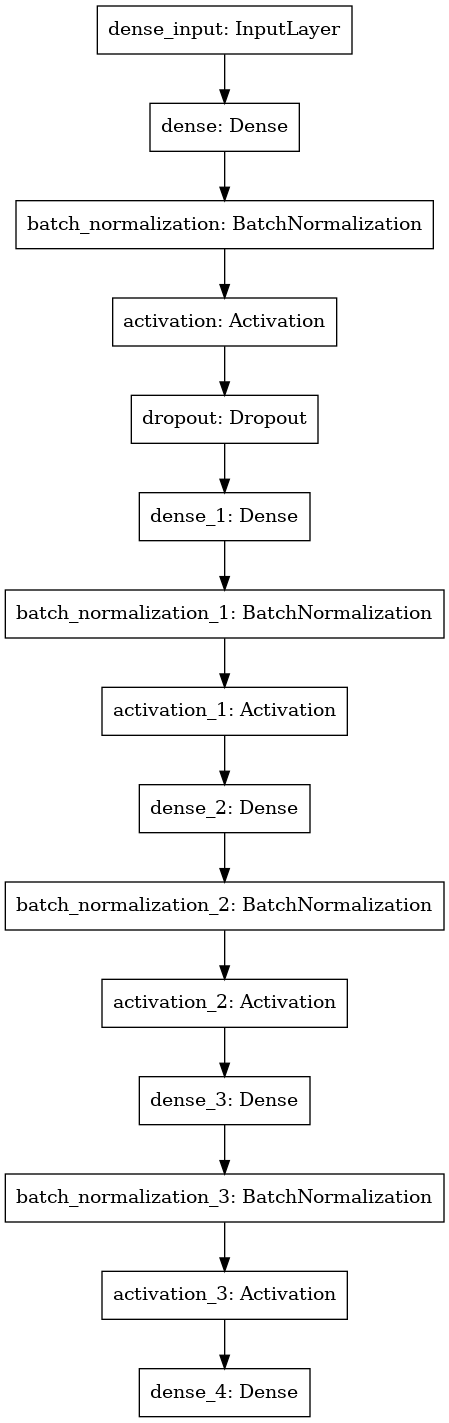

In [4]:
activation = 'elu'

keras_model = keras.Sequential([
    layers.Dense(units=32, input_shape=(X.shape[1:])),
    layers.BatchNormalization(), 
    layers.Activation(activation), 
    layers.Dropout(0.2), 
    
    layers.Dense(units=40), 
    layers.BatchNormalization(), 
    layers.Activation(activation), 
    
    layers.Dense(units=20), 
    layers.BatchNormalization(), 
    layers.Activation(activation), 
    
    layers.Dense(units=8), 
    layers.BatchNormalization(), 
    layers.Activation(activation), 
    
    layers.Dense(units=1, activation='sigmoid')    
])

fig = plot_model(keras_model)

es = cb.EarlyStopping(monitor='loss', patience=5, mode='min')
lr = cb.ReduceLROnPlateau(monitor='val_loss', patience=3, mindelta=1e-1)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.01)

keras_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
fig

In [5]:
history = keras_model.fit(X_train, y_train, epochs=50, batch_size=128, callbacks=[es, lr])

2022-11-18 12:45:40.503392: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
150/150 [==============================] - 3s 4ms/step - loss: 0.6136 - accuracy: 0.6626
Epoch 2/50
150/150 [==============================] - 1s 4ms/step - loss: 0.6051 - accuracy: 0.6694
Epoch 3/50
150/150 [==============================] - 1s 3ms/step - loss: 0.6014 - accuracy: 0.6727
Epoch 4/50
150/150 [==============================] - 1s 3ms/step - loss: 0.5999 - accuracy: 0.6722
Epoch 5/50
150/150 [==============================] - 1s 4ms/step - loss: 0.5998 - accuracy: 0.6743
Epoch 6/50
150/150 [==============================] - 1s 4ms/step - loss: 0.6001 - accuracy: 0.6727
Epoch 7/50
150/150 [==============================] - 1s 4ms/step - loss: 0.5992 - accuracy: 0.6742
Epoch 8/50
150/150 [==============================] - 1s 3ms/step - loss: 0.5974 - accuracy: 0.6755
Epoch 9/50
150/150 [==============================] - 1s 3ms/step - loss: 0.5980 - accuracy: 0.6747
Epoch 10/50
150/150 [==============================] - 1s 3ms/step - loss: 0.5981 - accuracy: 0.6745

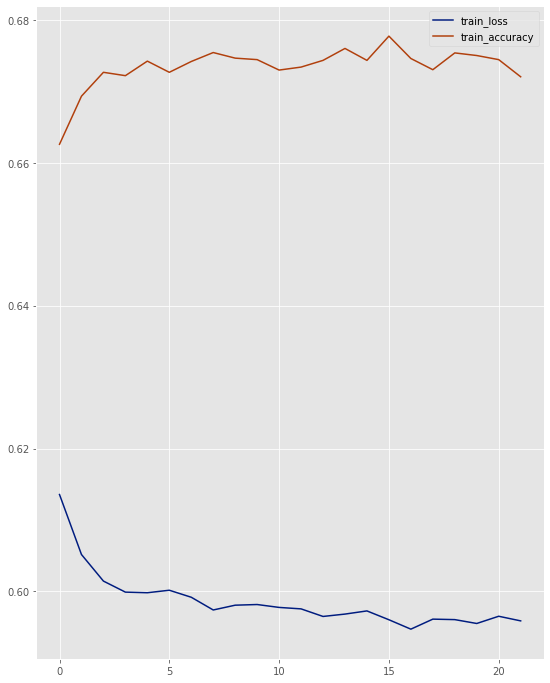

In [6]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='train_loss')
plt.plot(range(len(train_accuracy)), train_accuracy, label='train_accuracy')
plt.legend();

Accuracy score: 67.14733542319749


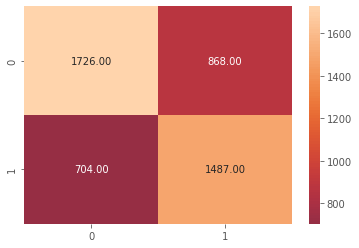

              precision    recall  f1-score   support

       False       0.71      0.67      0.69      2594
        True       0.63      0.68      0.65      2191

    accuracy                           0.67      4785
   macro avg       0.67      0.67      0.67      4785
weighted avg       0.67      0.67      0.67      4785

AUC: 67.20335908410625


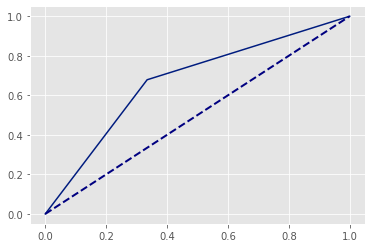

In [7]:
y_pred = keras_model.predict(X_test)>0.5
evaluate(y_pred, y_test)

# Random Forest

Accuracy score: 67.14733542319749


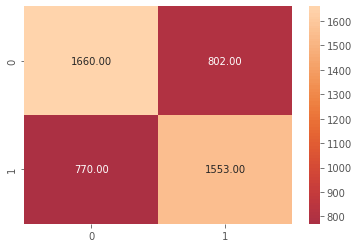

              precision    recall  f1-score   support

           0       0.68      0.67      0.68      2462
           1       0.66      0.67      0.66      2323

    accuracy                           0.67      4785
   macro avg       0.67      0.67      0.67      4785
weighted avg       0.67      0.67      0.67      4785

AUC: 67.13903244949579


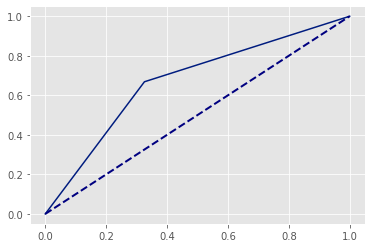

In [8]:
RFmodel = RandomForestClassifier()
RFmodel.fit(X_train, y_train)
y_pred = RFmodel.predict(X_test)
evaluate(y_pred, y_test)

# XGboost

Accuracy score: 67.14733542319749


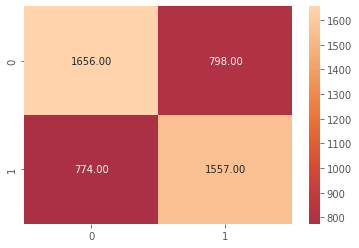

              precision    recall  f1-score   support

           0       0.68      0.67      0.68      2454
           1       0.66      0.67      0.66      2331

    accuracy                           0.67      4785
   macro avg       0.67      0.67      0.67      4785
weighted avg       0.67      0.67      0.67      4785

AUC: 67.13851469352691


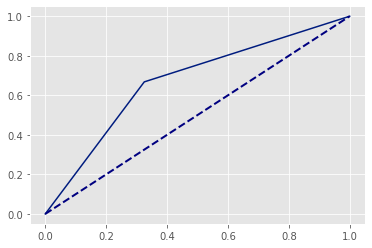

In [9]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
evaluate(y_pred, y_test)

<a id='p'></a>
<h1 style="background-color:#7F1431; font-weight:600; font-size:50px; text-align:center; padding:15px; color:#ffffff; border-radius:20px; margin:auto auto 50px auto">Predict World Cup winner ​🥇​</h1>

## First to predict two teams match's result we need to get their recent data in order to enter them into model to return match result, 
So we can split features entering models into three categories: 
1. Features remain constant over years.
    * home_team_continent, away_team_continent.
    
2. Features from historical data.
    * home_team_total_fifa_points, away_team_total_fifa_points.
    * home_team_fifa_rank, away_team_fifa_rank.
    * (home|away)_team_(goalkeeper|offense|defense|midfield)_score.
    
3. Features about match and relation between both teams.
    * shoot_out.
    * tournament.
    * total_fifa_points_diff, total_fifa_points_sum.
    * fifa_rank_diff, fifa_rank_sum.

In [10]:
def get_team_data(team: str) -> list:
    # team total fifa points
    home_FP = df.loc[(df['home_team']==team).values & (df['year'] >= 2021).values & (df['away_team'].isin(teams_worldcup)).values, 'home_team_total_fifa_points'].mean()
    away_FP = df.loc[(df['away_team']==team).values & (df['year'] >= 2021).values & (df['home_team'].isin(teams_worldcup)).values, 'away_team_total_fifa_points'].mean()
    fifa_points = np.mean([home_FP, away_FP])
    if np.isnan(fifa_points):
        home_FP = df.loc[(df['home_team']==team).values & (df['away_team'].isin(teams_worldcup)).values, 'home_team_total_fifa_points'].iloc[:2].mean()
        away_FP = df.loc[(df['away_team']==team).values & (df['home_team'].isin(teams_worldcup)).values, 'away_team_total_fifa_points'].iloc[:3].mean()
        fifa_points = np.mean([home_FP, away_FP])

    
    # team fifa rank
    home_FR = df.loc[(df['home_team']==team).values & (df['year'] >= 2021).values & (df['away_team'].isin(teams_worldcup)).values, 'home_team_fifa_rank'].mean()
    away_FR = df.loc[(df['away_team']==team).values & (df['year'] >= 2021).values & (df['home_team'].isin(teams_worldcup)).values, 'away_team_fifa_rank'].mean()
    fifa_rank = np.mean([home_FR, away_FR])
    if np.isnan(fifa_rank):
        home_FR = df.loc[(df['home_team']==team).values & (df['away_team'].isin(teams_worldcup)).values, 'home_team_fifa_rank'].iloc[:2].mean()
        away_FR = df.loc[(df['away_team']==team).values & (df['home_team'].isin(teams_worldcup)).values, 'away_team_fifa_rank'].iloc[:3].mean()
        fifa_rank= np.mean([home_FR, away_FR])

    
    # team continent
    continent = df.loc[df['home_team']==team, 'home_team_continent_encoded'].mode()[0]
    
    # scores
    home_scores = df.loc[(df['home_team']==team).values & (df['away_team'].isin(teams_worldcup)).values].sort_values(by='date').drop('home_team_score', axis=1).filter(regex='score').filter(regex='home').iloc[:5].mean()
    away_scores = df.loc[(df['away_team']==team).values & (df['home_team'].isin(teams_worldcup)).values].sort_values(by='date').drop('away_team_score', axis=1).filter(regex='score').filter(regex='away').iloc[:5].mean()
    scores = (home_scores.values + away_scores.values) / 2
    
    
    return [fifa_rank, fifa_points, continent] +  [*scores]

def prepare_data(team1_data: list, team2_data: list, tournament_rank:str, shoot_out:bool) -> np.ndarray:
    fifa_pts_diff = team1_data[1] - team2_data[1]
    fifa_pts_sum = team1_data[1] + team2_data[1]
    fifa_rank_diff = team1_data[0] - team2_data[0]
    fifa_rank_sum = team1_data[0] + team2_data[0]
    tournaments = [*tournament_rank_encoder.transform(np.array(tournament_rank).reshape(-1, 1)).toarray()[0]]
    X = np.array([team1_data[0], team2_data[0], team1_data[1], team2_data[1], shoot_out, team1_data[3], team2_data[3], *team1_data[4:], *team2_data[4:],
                 fifa_pts_diff, fifa_pts_sum, fifa_rank_diff, fifa_rank_sum, *tournaments, team1_data[2], team2_data[2]])
    return X.reshape(-1, 26)

<div style="background-color:#7F1431; color:#ffffff;
          padding:12px; margin-left:auto;margin-right:auto; border-radius:10px;">
<h1 style="font-weight:200px; font-size:30px;">
    FIFA World cup Qatar 2022 qualification's system:
</h1>
<font size=4 color='black'><strong>First Group stage:</strong></font><br> 
- There are 8 groups (from A to H) each Group contains 4 teams, every team will play three matches (will face each of his group teams once), then points of each time is calculated according to his results in these matches where: <br>
    
<font color='black' size=4>3 points for winner, 1 point for each team in case of draw, 0 points for loser.<br></font>
Only First and Second of each group will be qualified to the next stage (the round of 16).
    
<font color='black' size=4><strong>Second the round of 16:</strong></font><br>
    - First of each group will play one knock out matches against second of the adjacent group, where adjacent groups are: [(A, B), (C, D), (E, F), (G, H)].
    Winner of this match will pass to next stage (the round of 8).
    
<font color='black' size=4><strong>Third the round of 8:</strong></font><br>
    - Winners of two adjacent matches in round of 16 will play against each other to decide which team will qualify to the round of 4.
    
<font size=4 color='black'><strong>Fourth the round of 4:</strong></font><br>
    - Each pair of teams arrived to this stage will face to qualify to Final Match, since losers will face each other to determine third and forth place.
    
<font size=4 color='black'><strong>Final:</strong></font><br> 
    - The two winning teams will play the final to uncover the champion of FIFA World Cup Qatar 2022.    
</div>


<h1 style='color:#7f1431'>Group Stage</h1>
<img src='https://scontent.fcai20-2.fna.fbcdn.net/v/t39.30808-6/277590874_8036989222992770_8675255456783230048_n.jpg?_nc_cat=103&ccb=1-7&_nc_sid=730e14&_nc_ohc=hbapudhtPv0AX_KlW28&_nc_ht=scontent.fcai20-2.fna&oh=00_AfDk1SRKP-keZHS8ub_j3PjWjGeSXNmqI7hvNAVdZADPug&oe=63790EA8'></img>

In [11]:
def predict_match(team1, team2, shoot_out=0):
    team1 = get_team_data(team1)
    team2 = get_team_data(team2)
    inp1 = prepare_data(team1, team2, 'International', shoot_out=shoot_out)
    y_pred1 = keras_model.predict(inp1)
    
    inp2 = prepare_data(team2, team1, 'International', shoot_out=shoot_out)
    y_pred2 = keras_model.predict(inp2)
    
    y_pred = (1 + y_pred1 - y_pred2) / 2
    return y_pred

def calc_points(team1, team2):
    y_pred = predict_match(team1, team2)
    if (y_pred>=0.6):
        return 3, 0
    elif (y_pred<=0.4):
        return 0, 3
    else :
        return 1, 1

groups = np.array(teams_worldcup).reshape(8, 4)
groups_pts = []
for i, group in enumerate(groups):
    print(f'Group {i+1}: ', end=f"\n{20*'-'}\n")
    groups_pts.append(dict(zip(group, np.zeros(4))))
    matches = [*combinations(group, 2)]
    
    # play matches
    for team1, team2 in matches:
        pt1, pt2 = calc_points(team1, team2)
        print(f"{team1} : {pt1} VS {team2} : {pt2}")
        groups_pts[i][team1] += pt1
        groups_pts[i][team2] += pt2
    print(30*'=')

Group 1: 
--------------------
Qatar : 1 VS Ecuador : 1
Qatar : 3 VS Senegal : 0
Qatar : 0 VS Netherlands : 3
Ecuador : 3 VS Senegal : 0
Ecuador : 0 VS Netherlands : 3
Senegal : 0 VS Netherlands : 3
Group 2: 
--------------------
England : 3 VS IR Iran : 0
England : 1 VS USA : 1
England : 3 VS Wales : 0
IR Iran : 1 VS USA : 1
IR Iran : 1 VS Wales : 1
USA : 1 VS Wales : 1
Group 3: 
--------------------
Argentina : 3 VS Saudi Arabia : 0
Argentina : 1 VS Mexico : 1
Argentina : 3 VS Poland : 0
Saudi Arabia : 0 VS Mexico : 3
Saudi Arabia : 0 VS Poland : 3
Mexico : 1 VS Poland : 1
Group 4: 
--------------------
France : 3 VS Australia : 0
France : 1 VS Denmark : 1
France : 3 VS Tunisia : 0
Australia : 0 VS Denmark : 3
Australia : 3 VS Tunisia : 0
Denmark : 3 VS Tunisia : 0
Group 5: 
--------------------
Spain : 3 VS Costa Rica : 0
Spain : 1 VS Germany : 1
Spain : 3 VS Japan : 0
Costa Rica : 0 VS Germany : 3
Costa Rica : 0 VS Japan : 3
Germany : 1 VS Japan : 1
Group 6: 
--------------------
B

In [12]:
sorted_groups_pts = []
def draw_break(groups_pts):
    for i, group_pts in enumerate(groups_pts):
        group = dict(reversed(sorted(group_pts.items(), key=lambda item: item[1])))
        teams = [*group.keys()]
        points = [*group.values()]
        
        if points[0] <= points[1]:
            out = predict_match(teams[0], teams[1])
            if out < 0.5:
                temp = teams[0]
                teams[0] = teams[1]
                teams[1] = temp

        if points[1] <= points[2]:
            out = predict_match(teams[1], teams[2])
            if out < 0.5:
                temp = teams[1]
                teams[1] = teams[2]
                teams[2] = temp
                
        sorted_groups_pts.append(dict(zip(teams, points)))
    return sorted_groups_pts
    
sorted_groups_pts = draw_break(groups_pts)

sorted_teams = []
print(colored("Groups after group stage: \n", 'red'))
for group in sorted_groups_pts:
    print(group, end=f'\n{50*"-"}\n')
    teams = [*group.keys()]
    sorted_teams.append(teams[:2])
    
# the round of 16
to_16 = []
for i in range(0, 8, 2):
    to_16.append((sorted_teams[i][0], sorted_teams[i+1][1]))
    to_16.append((sorted_teams[i+1][0], sorted_teams[i][1]))
    

to_8 = []
print(colored(f'\n{50*"="}\nMatches results in the round of 16:\n{50*"-"}', 'red'))
for i, (team1, team2) in enumerate(to_16):
    out =  predict_match(team1, team2, shoot_out=1)
    winner = team1 if out > 0.5 else team2
    print(f'Match{i+1}: {team1} VS {team2}')
    print(f'Winner: {colored(winner, "green")}')
    to_8.append(winner)

Groups after group stage: 

{'Netherlands': 9.0, 'Qatar': 4.0, 'Ecuador': 4.0, 'Senegal': 0.0}
--------------------------------------------------
{'England': 7.0, 'USA': 3.0, 'Wales': 2.0, 'IR Iran': 2.0}
--------------------------------------------------
{'Argentina': 7.0, 'Mexico': 5.0, 'Poland': 4.0, 'Saudi Arabia': 0.0}
--------------------------------------------------
{'France': 7.0, 'Denmark': 7.0, 'Australia': 3.0, 'Tunisia': 0.0}
--------------------------------------------------
{'Spain': 7.0, 'Germany': 5.0, 'Japan': 4.0, 'Costa Rica': 0.0}
--------------------------------------------------
{'Belgium': 9.0, 'Croatia': 4.0, 'Morocco': 4.0, 'Canada': 0.0}
--------------------------------------------------
{'Brazil': 9.0, 'Switzerland': 6.0, 'Serbia': 3.0, 'Cameroon': 0.0}
--------------------------------------------------
{'Portugal': 7.0, 'Uruguay': 7.0, 'Korea Republic': 3.0, 'Ghana': 0.0}
--------------------------------------------------

Matches results in the round of 16

In [13]:
# the round of 8
to_8 = np.array(to_8).reshape(-1, 2)
to_4 = []
for i, (team1, team2) in enumerate(to_8):
    out =  predict_match(team1, team2, shoot_out=1)
    winner = team1 if out > 0.5 else team2
    print(f'Match{i+1}: {team1} VS {team2}')
    print(f'Winner: {colored(winner, "green")}')
    to_4.append(winner)

Match1: Netherlands VS England
Winner: England
Match2: Argentina VS France
Winner: France
Match3: Spain VS Belgium
Winner: Belgium
Match4: Brazil VS Portugal
Winner: Brazil


In [14]:
# the round of 4
to_4 = np.array(to_4).reshape(-1, 2)
to_final = []
to_third_place_playoff = []
for i, (team1, team2) in enumerate(to_4):
    out =  predict_match(team1, team2, shoot_out=1)
    winner = team1 if out > 0.5 else team2
    loser = team1 if out <= 0.5 else team2
    print(f'Match{i+1}: {team1} VS {team2}')
    print(f'Winner: {colored(winner, "green")}')
    to_final.append(winner)
    to_third_place_playoff.append(loser)

Match1: England VS France
Winner: France
Match2: Belgium VS Brazil
Winner: Brazil


In [15]:
# third place play-off
third_out = predict_match(*to_third_place_playoff, shoot_out=1)
third = to_third_place_playoff[1 - int(third_out>0.5)]
fourth = to_third_place_playoff[int(third_out>0.5)]

# Final 
final_out = predict_match(*to_final, shoot_out=1)
Winner = to_final[1 - int(final_out>0.5)]
second = to_final[int(final_out>0.5)]

print(f"Winner of the World Cup Qatar 2022: {colored(Winner, 'yellow')}")
print(f"Second place of the World Cup Qatar 2022: {colored(second, 'blue')}")
print(f"Third place of the World Cup Qatar 2022: {colored(third, 'red')}")
print(f"Fourth place of the World Cup Qatar 2022:", end=' ')
cprint(fourth, 'white', 'on_grey')

Winner of the World Cup Qatar 2022: Brazil
Second place of the World Cup Qatar 2022: France
Third place of the World Cup Qatar 2022: Belgium
Fourth place of the World Cup Qatar 2022: England
